In [61]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="ShowCode"></form>''')



## Data Science Tools on Big Canada Cities

__By José A. López__  
September 2019


# Data Science tools on Canada's Big  Cities
__By José A. López__

In this article I will show you how to explore if there are significant relationships between the categories of two variables categories.
To do it, I have obtained data from recent "Data Scientist" job publications in Canada's four major cities. I would like to know if there are certain tools are equally demanded across all cities or some tools are more sought after in some cities than in others.

## Data Load and Exploration

First of all, let's bring in and explore the data. Each publication includes the title, the company, the city, as well as the short and long job description.

In [65]:
import pandas as pd
import re
import os
from nltk.corpus import stopwords
import nltk
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

import numpy as np

import prince # Correspondenc Analysis (CA)

from scipy.stats import chi2_contingency
from plot_post import plot_post
from theano import tensor as tt
import pymc3 as pm

import matplotlib
matplotlib.rcParams.update({'font.size': 18})
import matplotlib.pyplot as plt

%matplotlib inline  


In [66]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,'/home/josalop/Documentos/Estad/Data Mining IA and ML/Bayesian Statistics/pymc3/chi2')

In [67]:
dfInit = pd.read_csv('data/jobs_db.csv')
print('Total examples:',dfInit.shape[0])
dfInit.head(3).T

Total examples: 271


,0,1,2
title,Data Scientist,Senior Data Scientist,Senior Economist or FSS Senior Analyst (2019-2...
company,Communications Security Establishment,Myticas Consulting,Bank of Canada
city,"Ottawa, ON","Ottawa, ON","Ottawa, ON"
summary,"Data analysts perform data review, data valida...","Conduct studies, tests and use advanced data m...","Access to numerous data sources, including con..."
description,"Data Scientist - Ottawa, ON - Indeed.com Find ...","Senior Data Scientist - Ottawa, ON - Indeed.co...",Senior Economist or FSS Senior Analyst (2019-2...


As expected the city of Toronto is the one with the most publications, followed by the others with Vancouver in last place.

In [68]:
dfInit.groupby('city').agg(np.count_nonzero)[['title']]

,title
city,
"Montreal, QC",47
"Ottawa, ON",25
"Toronto, ON",149
"Vancouver, BC",50


### Data Science top Requested Tools

I imagine that tools such as Python, R and Spark will be frequently required in publications. Nevertheless, some others could also be in high demand. So it will be better to see which are the important attributes in the extended text of the publications. Using Natural Language Processing (NLP) tools, we will extract the most frequent nouns. Surely the tools I've thought of will be on the list as well as some others I haven't thought of.

In [69]:
def extractPOS(str, posttags = ['NN']):
    txtBlob = TextBlob(str)
    return [i[0] for i in txtBlob.tags if i[1] in posttags]


In [70]:
def extractPOS(str, posttags = ['NN']):
    '''
    Function to retain selected parts of speach 
    '''
    txtBlob = TextBlob(str)
    return [i[0] for i in txtBlob.tags if i[1] in posttags]

corpus = dfInit['description'].tolist()

vectorizer = CountVectorizer(binary=True, tokenizer = extractPOS)
wordCounts = vectorizer.fit_transform(corpus)
sum_words = wordCounts.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)


In [71]:
words_freq[18:21]# To explore most demanded tools

[('python', 198), ('business', 191), ('machine', 184)]

Data Science tools frequencies:
Python 	 198
R 	 132
Sql 	 132
Spark 	 90
Hadoop 	 78
Tableau 	 63
Sas 	 42
Matlab 	 18
Spss 	 15


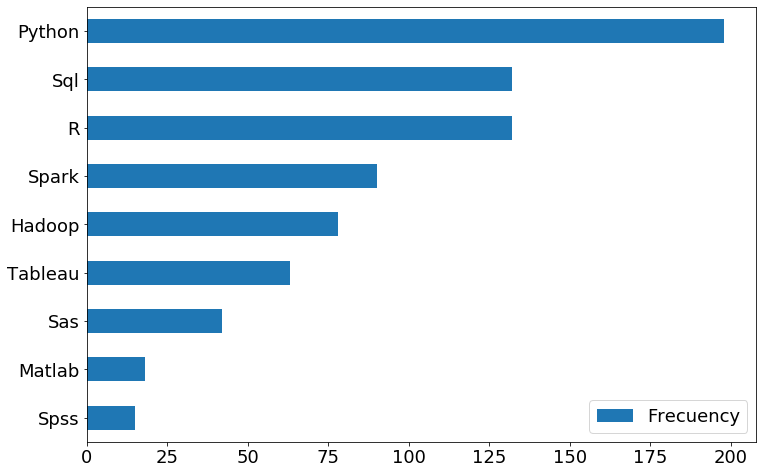

In [72]:
target_words_temp = ['hadoop', 'python', 'r', 'sql', 'spark', 'tableau', 'sas', 'matlab', 'spss']
print('Data Science tools frequencies:')
tools=[]
frecs = []
for t in [w for w in words_freq if w[0] in target_words_temp ]:
    tools.append(t[0].capitalize())
    frecs.append(t[1])
    print('{} \t {}'.format(t[0].capitalize(), t[1]))
tools_frecuencies_df = pd.DataFrame(frecs, index = tools, columns = ['Frecuency'])
matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize = (12,8))
tools_frecuencies_df.sort_values(by='Frecuency').plot(kind = 'barh', ax = ax)
plt.show()

The result shows that the most in-demand tools are Python, R and SQL, followed by the Big Data processing tools Spark and Hadoop. In other words, Open Source tools are in much greater demand than proprietary tools which stand at the end of the list. Actually, SAS, Matlab and SPSS are not high-demand attributes, but I've decided to add them to analyze them together.  

### Data Science Tools By City

The next step is to explore the number of times each tool has been mentioned in each city's publications.

In [73]:
word_idxt = [i for i in vectorizer.vocabulary_.items() if i[0] in target_words_temp]
target_words = [t[0] for t in word_idxt]
target_word_cols = pd.DataFrame(  wordCounts.T[[i[1] for i in word_idxt]].T.todense()
                                , columns = target_words)


tools_tbl = dfInit[['city']].join(target_word_cols).groupby(['city']).agg(np.sum)
tools_tbl


,python,r,tableau,spark,sql,hadoop,sas,matlab,spss
city,,,,,,,,,
"Montreal, QC",38,15,5,27,25,25,7,3,4
"Ottawa, ON",19,16,2,9,11,3,1,3,1
"Toronto, ON",111,79,43,41,78,38,32,11,8
"Vancouver, BC",30,22,13,13,18,12,2,1,2


If a city has a high inclination for a tool, compared to other cities, then the number of mentions of that tool will be much higher than what we would expect if the frequencies were randomly assigned. The chi squared ( $\chi^2$ ) statistic test can be performed to test this kind of relationship.  Let's see what the expected frequencies would be under the assumption of independence.


For the $\chi^2$ test it is necessary to have at least five examples on more than 80% of the table cells. So will merge the categories SAS, Matlab and SPSS which have very small frequencies.

#### Independence test

In [74]:
# Merge SAS matlab and spss
other_tools = ['sas', 'matlab', 'spss']
other_tools_df = pd.DataFrame(tools_tbl.loc[:, other_tools].sum(axis = 1)
                             , columns = ['sas_others'])
tools_cols = [c for c in tools_tbl.columns if c not in other_tools]
tools_df = tools_tbl.loc[:,tools_cols].join(other_tools_df)
tools_df.reset_index().to_csv('data/tools_df.csv', index = False)

tools_df = pd.read_csv('data/tools_df.csv')
tools_df.index = tools_df.city
tools_df.drop(['city'], inplace = True, axis = 1)
tools_df.columns.rename('tools', inplace=True)
tools_df



tools,python,r,tableau,spark,sql,hadoop,sas_others
city,,,,,,,
"Montreal, QC",38,15,5,27,25,25,14
"Ottawa, ON",19,16,2,9,11,3,5
"Toronto, ON",111,79,43,41,78,38,51
"Vancouver, BC",30,22,13,13,18,12,5


Now, let's perform the $\chi ^2$ test.

In [75]:
g, p, dof, expctd = chi2_contingency(tools_df, correction=True)
print('Chi2 test p val: %.4f'%p)
expctd_df = pd.DataFrame(expctd, columns = tools_df.columns, index = tools_df.index)
print('Expected Matrix')
expctd_df

Chi2 test p val: 0.0030
Expected Matrix


tools,python,r,tableau,spark,sql,hadoop,sas_others
city,,,,,,,
"Montreal, QC",38.414062,25.609375,12.222656,17.460938,25.609375,15.132812,14.550781
"Ottawa, ON",16.757812,11.171875,5.332031,7.617188,11.171875,6.601562,6.347656
"Toronto, ON",113.695312,75.796875,36.175781,51.679688,75.796875,44.789062,43.066406
"Vancouver, BC",29.132812,19.421875,9.269531,13.242188,19.421875,11.476562,11.035156


The result indicates a likelihood of 3 in a thousand to get the observed frequencies by chance under the assumption of independence of cities and tools. This means that we have strong evidence of a relationship of cities and tools. In other words, at least one of the cities has a higher preference for  one or more tools than its peers. We can also see which would be the expected frequencies under the independence assumption.

This brings us to the next question. The $\chi 2$ statistic allows us to discover that a relationship exists, however we do not know which cities and which tools are related. One way to find out is to perform chi2 statistics for each cell in our table. Since cells are not independent of each other, Bonferroni's criterion is used, establishing a stricter criterion such as a .995 confidence level, for example, to consider that there is a relationship. 

However, in this project we will use the Bayesian approach to determine are the related variables. The advantage of this method is that it gives us confidence intervals that allow us to better interpret the strength of relationships.

#### Cities and tools individual relationships

Based on the excelent  [John Kruschke](https://www.amazon.com/Doing-Bayesian-Data-Analysis-Tutorial/dp/0124058884/ref=sr_1_fkmr0_1?keywords=Kruschke+%28AKA+the+puppy+book%29&qid=1570031878&s=books&sr=1-1-fkmr0)  (AKA the puppy book), we need to modify the Bayesian ANOVA 2 model using poisson exponential to model contingency tables (Bayes chi2 test). The bayesian chi2 model is very similar to regular bayes ANOVA with 3 differences:

1. Exponentiation of $\beta 0+\beta X$ i.e. $exp(\beta 0+\beta X)$
2. Use of poisson ($\lambda$) as likelihood ($\lambda$ hyperparams would be same normal as in ANOVA but exponenciated)
3. Omit the sigma hyper-parameter on likelihood.
    
So I modified an ANOVA model, based on the Kruschke book, implemented in python by [Oswaldo Martin](https://github.com/aloctavodia/Doing_bayesian_data_analysis) to get the Bayesian Chi2 to use here.

As is well known, the Bayesian approach models the observed data, as being generated from a probabiity distribution and fits the observed data to generate many instances allowing to get confidence intervals of the parameters such as the mean or the standar deviation. Our example is based on the pymc3 python library to make all those duties. 

In [76]:
chi2_df = tools_df

x1_data = pd.Categorical(np.tile(chi2_df.columns.values, chi2_df.shape[0]))
x2_data = pd.Categorical(np.repeat(chi2_df.index.values, chi2_df.shape[1]))
y_data = np.ravel(chi2_df.values)

#Put extended data together in a df
data_record = pd.DataFrame({'x1': x1_data, 'x2': x2_data, 'y': y_data})
#data_record_sortx1 = data_record.sort_values(by = ['x1'])

y = data_record.y
x1 = pd.Categorical(data_record['x1']).codes
x1names = data_record['x1'].values
x2 = pd.Categorical(data_record['x2']).codes
x2names = data_record['x2'].values
Ntotal = len(y)
Nx1Lvl = len(set(x1))
Nx2Lvl = len(set(x2))

In [77]:
# EXAMINE THE RESULTS

with pm.Model() as model:
    # define the hyperpriors

    a1_SD_unabs = pm.StudentT('a1_SD_unabs', mu=0, lam=0.001, nu=1)
    a1_SD = abs(a1_SD_unabs) + 0.1
    a1tau = 1 / a1_SD**2

    a2_SD_unabs = pm.StudentT('a2_SD_unabs', mu=0, lam=0.001, nu=1)
    a2_SD = abs(a2_SD_unabs) + 0.1
    a2tau = 1 / a2_SD**2
    
    a1a2_SD_unabs = pm.StudentT('a1a2_SD_unabs', mu=0, lam=0.001, nu=1)
    a1a2_SD = abs(a1a2_SD_unabs) + 0.1
    a1a2tau = 1 / a1a2_SD**2


    # define the priors
    sigma = pm.Uniform('sigma', 0, 10) # y values are assumed to be standardized
    tau = 1 / sigma**2                
    
    a0 = pm.Normal('a0', mu=0, tau=0.001) # y values are assumed to be standardized
   
    a1 = pm.Normal('a1', mu=0 , tau=a1tau, shape=Nx1Lvl)
    a2 = pm.Normal('a2', mu=0 , tau=a2tau, shape=Nx2Lvl)
    a1a2 = pm.Normal('a1a2', mu=0 , tau=a1a2tau, shape=[Nx1Lvl, Nx2Lvl])

    b1 = pm.Deterministic('b1', a1 - tt.mean(a1))
    b2 = pm.Deterministic('b2', a2 - tt.mean(a2))
    b1b2 = pm.Deterministic('b1b2', a1a2 - tt.mean(a1a2))
    
    #mu = a0 + b1[x1] + b2[x2] + b1b2[x1, x2] #mu on anova with normal likelihood
    mu = np.exp(a0 + b1[x1] + b2[x2] + b1b2[x1, x2])  #lambda on poisson exponential chi2 test
    # define the likelihoodp
    
    #yl = pm.Normal('yl', mu=mu, tau=tau, observed=z)
    yl = pm.Poisson('yl', mu = mu, observed = y)
    
    # Generate a MCMC chain
    start = pm.find_MAP()
    steps = pm.Metropolis()
    trace = pm.sample(20000, steps, start=start, progressbar=True, random_seed=19238)

logp = -128.65, ||grad|| = 0.62577: 100%|██████████| 17/17 [00:00<00:00, 696.84it/s]  
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [a1a2]
>Metropolis: [a2]
>Metropolis: [a1]
>Metropolis: [a0]
>Metropolis: [sigma]
>Metropolis: [a1a2_SD_unabs]
>Metropolis: [a2_SD_unabs]
>Metropolis: [a1_SD_unabs]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:24<00:00, 357.82draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


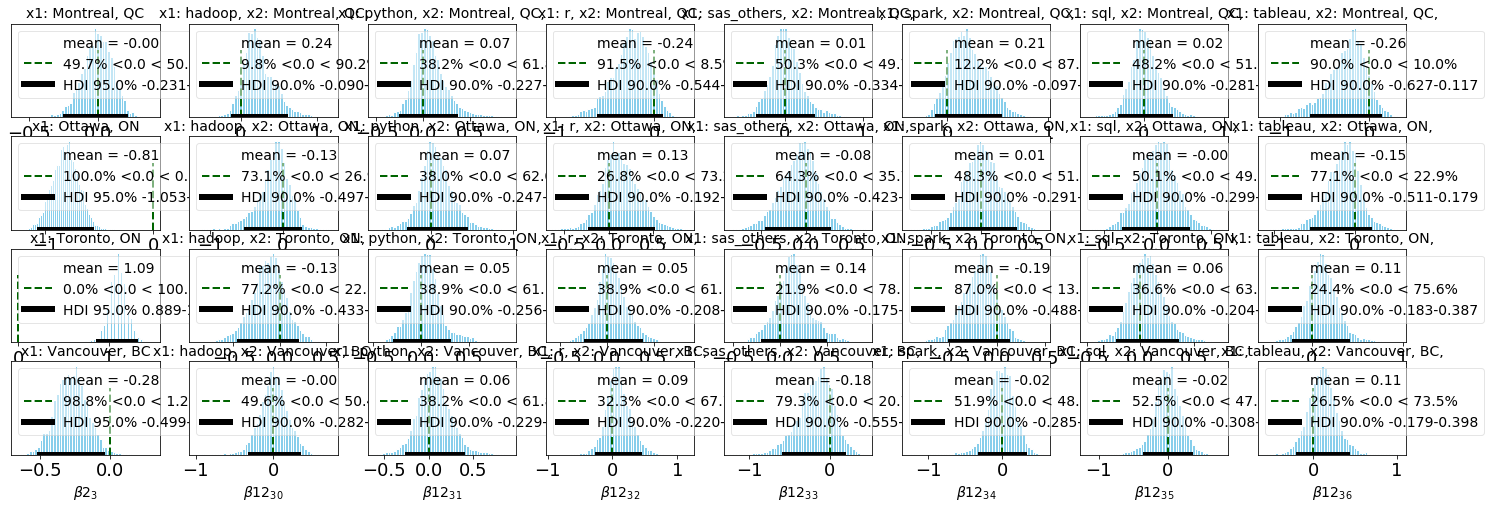

In [78]:
burnin = 2000


# Extract values of 'a'
b0_sample = trace['a0'][burnin:] #originally a0_sample
b1_sample = trace['b1'][burnin:]
b2_sample = trace['b2'][burnin:]
b1b2_sample = trace['b1b2'][burnin:]

#b0_sample = a0_sample * np.std(y) + np.mean(y)
#b1_sample = b1_sample * np.std(y)
#b2_sample = b2_sample * np.std(y)
#b1b2_sample = b1b2_sample * np.std(y)

nrows = chi2_df.shape[0]
ncols = chi2_df.shape[1]
credib_level = 0.9
#plt.figure(figsize=(25,22))
fig, axes = plt.subplots(nrows = nrows+1, ncols = ncols+1, figsize=(25,10)) #
plt.subplot(nrows,ncols,1) #Plot baseline on top left place
plot_post(b0_sample, xlab=r'$\beta0$', cred_mass=credib_level,
              show_mode=False, framealpha=0.5,
              bins=50, title='Baseline')
plt.xlim(b0_sample.min(), b0_sample.max());
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
count = 2  # Loop from 2nd plot to build all other plots
plt_smries = dict()
for i in range(len(b1_sample[0])):
    plt.subplot(nrows, nrows+1, count)
    plot_post(b1_sample[:,i], xlab=r'$\beta1_{%s}$' % i, cred_mass=credib_level,
              show_mode=False, framealpha=0.5,
              bins=50, title='x1: %s' % x1names.categories[i])
    #print('i: {}, x1names[i] {}'.format(i, x1names.categories[i] ))
    count += 1


for i in range(len(b2_sample[0])):
    plt.subplot(nrows+1, ncols+1, count)
    plot_post(b2_sample[:,i], xlab=r'$\beta2_{%s}$' % i,
              show_mode=False, framealpha=0.5,
              bins=50, title='x1: %s' % x2names.categories[i], comp_val=0.0)
    #print('x2names: {}, {}: '.format(i, x2names.categories[i]))    
    
    count += 1
    for j in range(len(b1_sample[0])):
        plt.subplot(nrows+1, ncols+1, count)
        plt_smries['{}_{}'.format(x1names.categories[j], x2names.categories[i])] = plot_post(b1b2_sample[:,j,i]
                                 , cred_mass=credib_level, xlab=r'$\beta12_{%s%s}$' % (i, j)
                                 ,show_mode=False, framealpha=0.5,
              bins=50, title='x1: %s, x2: %s,' % (x1names.categories[j], x2names.categories[i]), comp_val=0.0)
        #print('i,j: {},{} x1names[j], x2names[i]: {},{}'.format(i,j, x1names.categories[j], x2names.categories[i]))
        count += 1

From the above plots we can see that Montreal has high inclination to Hadoop and Spark tools, with 90% and 88% probability of the Credibility interval to be higher than 0 (PC>0) corresponding to a positive relationship. There is, however, a 10% probability to be negatively related. So I create a new measure that mixes both probabilities, which I call Certainty, by substracting 50 and multiplying the result by 2. The result will give values in the 0-100% scale with a sign that can be interpreted as the direction of the relationship. So, translating these probabilities to that scale, we can state, with a certainty close to 80% of not being wrong, that Montreal has a bigger inclination to big data tools than the other Canadian big cities while getting a low affinity for Tableau and R. These results are summarized in the below table.

In [79]:
#Inspect results. Note possibly better to name i,j to use name as matrix reference
pc_gt_comp_df = pd.DataFrame(None, index = list(plt_smries.keys())
                             , columns = ['PC>0', 'Certainty'] )
for i,cell in enumerate(pc_gt_comp_df.index):
    pc_gt_comp_val = plt_smries[cell]['pc_gt_comp_val']
    certainty = (pc_gt_comp_val-50)*2
    pc_gt_comp_df.iloc[i]   = [pc_gt_comp_val, certainty]
    

certainty_threshold = 24
over_threshold =  abs(pc_gt_comp_df.Certainty) > certainty_threshold
pc_gt_comp_df.sort_values('PC>0', ascending = False).loc[over_threshold,:]

,PC>0,Certainty
"hadoop_Montreal, QC",90.1816,80.3632
"spark_Montreal, QC",87.8053,75.6105
"sas_others_Toronto, ON",78.0789,56.1579
"tableau_Toronto, ON",75.6053,51.2105
"tableau_Vancouver, BC",73.4526,46.9053
"r_Ottawa, ON",73.2184,46.4368
"r_Vancouver, BC",67.7105,35.4211
"sql_Toronto, ON",63.4342,26.8684
"python_Ottawa, ON",62.05,24.1
"sas_others_Ottawa, ON",35.7053,-28.5895


On the same way, using the above relationships table, we can state with a lower certainty, that Toronto shows  a preference for proprietary tools such as SAS and Tableau. This could be maybe because of Toronto being Canadian center of Finance industries such as insurance and banks which seem to be the last ones to adopt the open source tools. It would be interesting to investigate furder relationships  on industry sectors. At the same certainty level, we can see that this city also has lower preference for Spark, compared with his counterparts.

There are some other relationships on a low certainty level like the negatively relations of Vancouver with proprietary SAS and other tools, Ottawa with Tableau and Toronto with Hadoop.

For the rest of the relationships presented in the table the evidence is rather weak and they could be due to chance. For example Vancouver's preference for the use of R, with a probability of having a positive relationship 67% (i.e. 2/3), means that we have a  and 1/3 of having a relationship in the oposit way. Probability of CI>0 at 60%  it means we there is 40% chance that the relationship be in the opposite way. So on those cases we have a very low certainty about having a relationship.

A way to stablish certainty is to consider quantiles as follows:  
__High__: 75-100  
__Low__: 50-75    
__Uncertain__: 0-50 

### Correspondence Analysis

There is a way to inspect our results graphically using correspondence analysis. The graph is the result of matrix decomposition into single values, SVD applied to the matrix of normalized chi2 distances between the frequencies of the contingency table we are examining. 

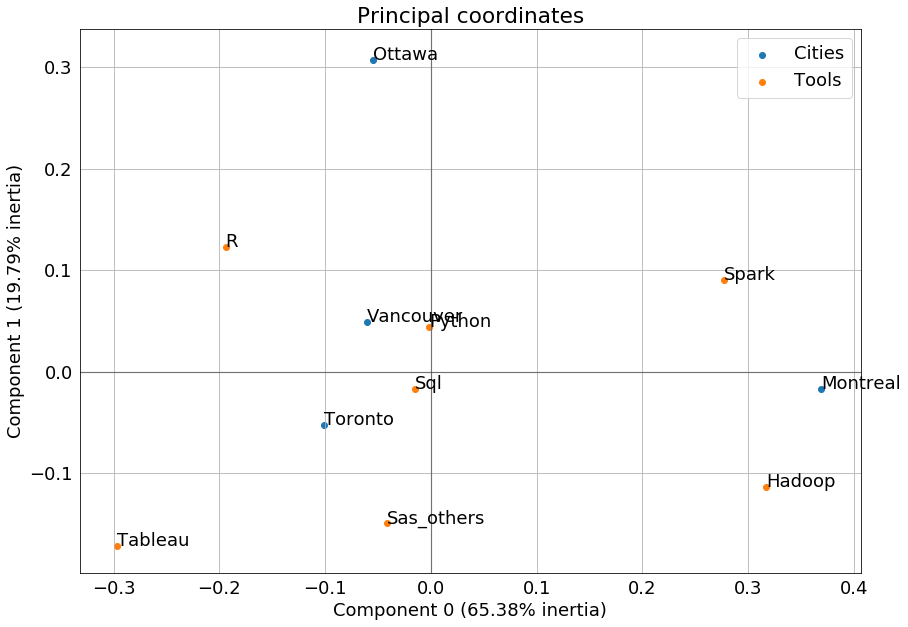

In [80]:
#  Make ccrrespondence Analysis
import seaborn as sns

ca = prince.CA(
     n_components=2,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
     )

ca = ca.fit(tools_df)
#fig, ax = plt.subplots(figsize = (14, 10))
# Capitalize columns and indexes
tools_df.columns = pd.Series([c.capitalize() for c in tools_df.columns], name = 'Tools')
tools_df.index = pd.Series([c.split(',')[0].capitalize() for c in tools_df.index], name = 'Cities')
ax = ca.plot_coordinates(
     X=tools_df,
     ax=None,
    
     x_component=0,
     y_component=1,
     show_row_labels=True,
     show_col_labels=True,
     figsize = (14,10), )
#plt.scatter(city_coords.loc['Montreal',:][0], city_coords.loc['Montreal',:][1], s=120, marker='o', c='b')
plt.show()
#ax.get_figure().savefig('images/ca_coordinates.svg')

The smaller the angle between objects, the greater their relationship and the further away from the center, the greater the strength of that relationship. So it is clear that Montreal is positively related to the treatment tools of Big Data Spark and Hadoop and negatively related with R and Tableau, as we just saw. Toronto, on the other hand, shows a weaker relationship with the proprietary tools.
Although on the map we can see that Vancouver and Python are close, thanks to the analysis previously carried out, we know that there is no evidence that this relationship is significant. Finally we can see that sql is the closest point to the origin, which means that it is a tool requested in a very homogeneous way in all cities.

## Conslusions

In this report we have examined the distribution of demand for data science tools in the largest Canadian cities. The result has shown that there are preferences for certain tools in some cities. It has also allowed us to see that some tools such as SQL are uniformly searched in all cities. 
It would be interesting, perhaps, to continue the analysis according to the sector of activity to see if the there is a difference in the demanded tools by different industrial sectors.  

Finally, as an extra result, below is an interactive Correspondence Analysis plot, which allows to understand possible relationships, their strenghts and directions. This kind of display could be served on a dashboard server for the decisions maker users.

In [81]:
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import ipywidgets as widgets


In [183]:

target_city = widgets.Dropdown(options = list(tools_df.index), value = 'Montreal')
measure = widgets.Dropdown(options = list(pc_gt_comp_df.columns), value = 'Certainty')
# An HBox lays out its children horizontally
ui = widgets.HBox([target_city, measure])


In [184]:
columncoords = ca.column_coordinates(tools_df)
row_coords = ca.row_coordinates(tools_df)
column_coords
def interactive_plot(target_city, measure ):
    print(target_city)
    mask = sorted([i for i in pc_gt_comp_df.index if target_city in i] )
    city_df = pc_gt_comp_df.loc[mask,:]
    city_df.index = [i[0:i.rfind('_')].capitalize() for i in city_df.index]
    city_df
    city_coords = column_coords.join(city_df)
    city_coords
    plot_df = city_coords.reset_index().drop('index',axis = 1)

    ax = ca.plot_coordinates(
         X=tools_df,
         ax=None, 
         x_component=0,
         y_component=1,
         show_row_labels=True,
         show_col_labels=True,
         figsize = (14,10) )

    sns.scatterplot(plot_df.iloc[:,0], plot_df.iloc[:,1], s = 120, alpha = 1
                    , hue =[round(i,2) for i in plot_df[measure]]
                    , palette = sns.diverging_palette(220, 10, sep=80, n=len(column_coords.index))
                                                  )
    
    plt.legend(loc='upper left')
    plt.show()


In [185]:
out = widgets.interactive_output(interactive_plot, {'target_city': target_city, 'measure': measure})
display(ui, out)

Output()